cpu
Downsampled MNIST tensor shape: torch.Size([14, 14])


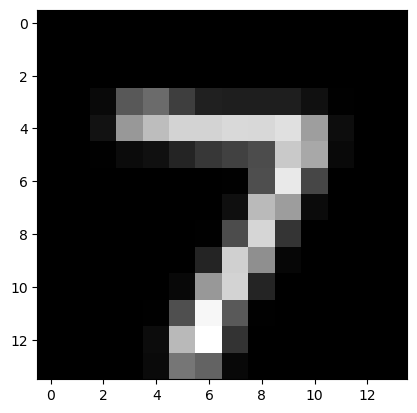

In [1]:
import os
import numpy as np
import time 
from collections import defaultdict
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch_geometric.data import Data, DataLoader  # PyG Data and loader
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define the transform to downsample the images to 14x14 pixels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

test_features, test_labels = next(iter(test_loader))
true = test_features[0].squeeze()
plt.imshow(true, cmap="gray")
print(f"Downsampled MNIST tensor shape: {true.shape}")

In [2]:
# Define MNIST classifier MLP class for dataset
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(196, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
def test_mlp(model, test_loader, device = device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

# Git Rebasin Permutation Canonicalization: 

In [4]:
# Functions for permutations and weight matching
def permute_layer_weights(layer, perm):
    """Permutes weights and biases of a layer based on the given permutation matrix."""
    weight = layer.weight.data.clone()
    bias = layer.bias.data.clone()

    # Permute rows of weights (output dimension)
    layer.weight.data = weight[perm, :]

    # Permute bias (output dimension)
    layer.bias.data = bias[perm]
    return layer

def permute_model(model, permutations):
    """Applies a list of permutations to a model's layers."""
    permute_layer_weights(model.fc1, permutations[0])
    permute_layer_weights(model.fc2, permutations[1])

    # Adjust input weights of the second hidden layer
    model.fc2.weight.data = model.fc2.weight.data[:, permutations[0]]
    # Adjust input weights of the output layer
    model.fc3.weight.data = model.fc3.weight.data[:, permutations[1]]
    return model

# Functions to permute weights and adjust input weights
def apply_permutation(layer, perm):
    """
    Applies the given permutation to the weights and biases of a layer.
    Args:
        layer: The layer to permute.
        perm: The permutation array.
    """
    # Permute rows (output dimension) of weights
    layer.weight.data = layer.weight.data[perm, :]
    # Permute biases
    layer.bias.data = layer.bias.data[perm]

def adjust_input_weights(layer, perm):
    """
    Adjusts the input wei
    ghts of a layer according to the permutation of the previous layer.
    Args:
        layer: The layer to adjust.
        perm: The permutation array of the previous layer.
    """
    layer.weight.data = layer.weight.data[:, perm]
    
def generate_permutation_matrix(hidden_dim):
    """Generates a random permutation matrix."""
    perm = np.random.permutation(hidden_dim)
    return torch.tensor(perm, dtype=torch.long)

def compute_similarity_matrix(weights_a, weights_b):
    """
    Computes the similarity matrix for two layers' weights.
    """
    weights_a = weights_a.view(weights_a.size(0), -1)
    weights_b = weights_b.view(weights_b.size(0), -1)
    return torch.matmul(weights_a, weights_b.T)

def get_permuted_weights(weights, perm):
    """
    Permutes the rows of weights based on the given permutation.
    """
    return weights[perm, :]


def weight_matching(rng, model_a, model_b, max_iter=100, init_perm=None):
    """
    Optimizes permutations to match Model B to Model A.
    """
    layers = ['fc1', 'fc2', 'fc3']
    perm_sizes = {layer: getattr(model_a, layer).weight.size(0) for layer in layers[:-1]}
    perm = {layer: np.arange(size) for layer, size in perm_sizes.items()} if init_perm is None else init_perm

    for iteration in range(max_iter):
        progress = False
        for layer in layers[:-1]:  # Exclude the output layer (fc3)
            n = perm_sizes[layer]
            similarity_matrix = compute_similarity_matrix(
                getattr(model_a, layer).weight.data,
                get_permuted_weights(getattr(model_b, layer).weight.data, perm[layer])
            )
            row_ind, col_ind = linear_sum_assignment(similarity_matrix.numpy(), maximize=True)

            old_score = np.sum(similarity_matrix.numpy()[np.arange(n), perm[layer]])
            new_score = np.sum(similarity_matrix.numpy()[np.arange(n), col_ind])

            if new_score > old_score:
                perm[layer] = col_ind
                progress = True

        if not progress:
            break

    return perm, new_score

def rebase_model_b_to_a(rng, model_a, model_b, max_iter=100):
    """
    Rebases Model B to match Model A using weight matching.
    """
    # Generate initial permutations
    init_perm = {layer: generate_permutation_matrix(getattr(model_a, layer).weight.size(0)) for layer in ['fc1', 'fc2']}
    
    # Perform weight matching
    permutations, score = weight_matching(rng, model_a, model_b, max_iter=max_iter, init_perm=init_perm)
    
    # Apply the permutations to Model B
    model_b = permute_model(model_b, [permutations['fc1'], permutations['fc2']])
    
    return model_b, permutations, score

def load_model_weights(model, weight_path):
    # Load weights and biases
    weights, biases = torch.load(weight_path)
    model.fc1.weight.data = weights[0]
    model.fc2.weight.data = weights[1]
    model.fc3.weight.data = weights[2]
    model.fc1.bias.data = biases[0]
    model.fc2.bias.data = biases[1]
    model.fc3.bias.data = biases[2]
    return model

def reconstruct_model(model, final_permutations):
    """
    Reconstruct model_b by applying the final permutations to its layers.
    Args:
        model_b (MLP): The model to be reconstructed.
        final_permutations (dict): Dictionary containing layer-wise permutations.
    Returns:
        MLP: The reconstructed model.
    """
    # Apply permutations to fc1 layer
    apply_permutation(model.fc1, final_permutations[1]['fc1'])
    adjust_input_weights(model.fc2, final_permutations[1]['fc1'])
    
    # Apply permutations to fc2 layer
    apply_permutation(model.fc2, final_permutations[1]['fc2'])
    adjust_input_weights(model.fc3, final_permutations[1]['fc2'])
    
    # Return the reconstructed model
    return model

def extract_weights_and_biases(model):
    """Flatten the weights and biases of each layer in the model into a single vector."""
    all_weights_biases = []
    
    # Flatten weights and biases for each layer
    for layer_name in ['fc1', 'fc2', 'fc3']:
        weights = getattr(model, layer_name).weight.data.numpy().flatten()  # Flatten the weights
        biases = getattr(model, layer_name).bias.data.numpy().flatten()    # Flatten the biases
        all_weights_biases.extend(weights)
        all_weights_biases.extend(biases)
    
    return np.array(all_weights_biases)

def get_permuted_models_data(ref_point=0, N = 10, path = f"models/reduced_mlp_weights_{0}.pt"):
    ref_model = MLP()
    ref_model_path = path #f"models/reduced_mlp_weights_{ref_point}.pt"
#     ref_model_path =   f"models/dropout_mlp_weights_{ref_point}.pt"

    ref_model = load_model_weights(ref_model, ref_model_path)
    
    org_models=[]
    permuted_models = []
    full_times = []
    rebasin_times = []
    scores = []
    rng = np.random.default_rng(42)

    for i in range(0,N):
        if i == ref_point:
            continue
        all_start = time.time() # start timing
        model_path = f"models/reduced_mlp_weights_{i}.pt"
#         model_path = f"models/dropout_mlp_weights_{i}.pt"
        
        model = MLP()
        model = load_model_weights(model, model_path)
        org_models.append(model)
        loaded_model = time.time() # end timing for loading the model from .pth file
        
        reconstructed_model, final_permutations, score = rebase_model_b_to_a(rng, ref_model, model, max_iter=100)
        scores.append(score)
        permuted_models.append(reconstructed_model)
        all_end = time.time() # end timing for the entire loop
        
        full_times.append(all_end - all_start)
        rebasin_times.append(all_end - loaded_model)
        
#         print(f"Org model accuracy:{test_mlp(model, test_loader)} Reconstructed model accuracy:{test_mlp(reconstructed_model, test_loader)}")
    return org_models, permuted_models, scores, rebasin_times


In [5]:
org_models, permuted_models, scores, rebasin_times = get_permuted_models_data(ref_point=0, N = 45) 

/var/folders/js/697gbr4j3lzdh9ccy7qxb5ph0000gn/T/ipykernel_63343/800785483.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights, biases = torch.load(weight_path)


In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

###############################
# 1. Dataset: Neuron-level Graph Representation
###############################
# class MLPGraphDatasetNeurons(torch.utils.data.Dataset):
#     def __init__(self, model_folder):
#         # Collect all .pt files in the folder.
#         self.model_paths = [os.path.join(model_folder, fname) 
#                             for fname in os.listdir(model_folder) if fname.endswith('.pt')]

#     def __len__(self):
#         return len(self.model_paths)

#     def __getitem__(self, idx):
#         # Each file stores (weights, biases) using weights_only=True.
#         weights, biases = torch.load(self.model_paths[idx], weights_only=True)
#         # --- Build Node Features ---
#         # Input layer: use the input dimension from the first weight matrix.
#         input_dim = weights[0].shape[1]
#         input_feats = torch.zeros(input_dim, 1)
#         node_features = [input_feats]
#         for b in biases:
#             # Each bias is a 1D tensor; reshape it as a column vector.
#             node_feats = b.view(-1, 1)
#             node_features.append(node_feats)
#         x = torch.cat(node_features, dim=0)

#         # --- Build Edges and Edge Attributes ---
#         edge_index_list = []
#         edge_attr_list = []
#         offset = 0  # starting index for current layer's nodes
#         for w in weights:
#             in_dim = w.shape[1]    # nodes in source layer
#             out_dim = w.shape[0]   # nodes in destination layer
#             src_offset = offset
#             dst_offset = offset + in_dim
#             for i_out in range(out_dim):
#                 for j_in in range(in_dim):
#                     src = src_offset + j_in
#                     dst = dst_offset + i_out
#                     edge_index_list.append([src, dst])
#                     edge_attr_list.append([w[i_out, j_in].item()])
#             offset += in_dim
#         # Convert lists into tensors.
#         edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
#         edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
#         return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

class MLPGraphDatasetNeuronsFromList(torch.utils.data.Dataset):
    def __init__(self, mlp_list):
        """
        mlp_list: a list of MLP objects.
        """
        self.models = mlp_list

    def __len__(self):
        return len(self.models)

    def __getitem__(self, idx):
        # Get the MLP instance from the list.
        mlp = self.models[idx]
        # Extract weights and biases directly from the model's layers.
        # We assume the model has attributes fc1, fc2, fc3.
        weights = [mlp.fc1.weight, mlp.fc2.weight, mlp.fc3.weight]
        biases = [mlp.fc1.bias, mlp.fc2.bias, mlp.fc3.bias]

        # --- Build Node Features ---
        # Input layer: create nodes based on the input dimension of fc1.
        input_dim = weights[0].shape[1]
        input_feats = torch.zeros(input_dim, 1)
        # For subsequent layers, use the bias of each layer as the node feature.
        node_features = [input_feats]
        for b in biases:
            node_feats = b.view(-1, 1)
            node_features.append(node_feats)
        # Concatenate features from all layers; total nodes = input_dim + sum(layer output sizes)
        x = torch.cat(node_features, dim=0)

        # --- Build Edges and Edge Attributes ---
        edge_index_list = []
        edge_attr_list = []
        offset = 0  # starting index for current layer's nodes
        # Iterate over each weight matrix corresponding to a layer.
        for w in weights:
            in_dim = w.shape[1]    # number of nodes in source layer
            out_dim = w.shape[0]   # number of nodes in destination layer
            src_offset = offset
            dst_offset = offset + in_dim
            for i_out in range(out_dim):
                for j_in in range(in_dim):
                    src = src_offset + j_in
                    dst = dst_offset + i_out
                    edge_index_list.append([src, dst])
                    edge_attr_list.append([w[i_out, j_in].item()])
            offset += in_dim  # move the offset for the next layer

        # Convert lists to torch tensors.
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

def vgae_to_mlp(generated_data):
    """
    generated_data: a Data object that has the reconstructed node features (x)
    and edge attributes (edge_attr).  
    The original graph was built as:
      - First 196 nodes: input layer,
      - Next 32 nodes: fc1 neurons,
      - Next 32 nodes: fc2 neurons,
      - Next 10 nodes: fc3 neurons.
    Edge ordering is:
      - fc1: edges from input (196 nodes) to fc1 (32 nodes) in a nested loop:
             for i in range(32): for j in range(196)
      - fc2: edges from fc1 (32 nodes) to fc2 (32 nodes)
      - fc3: edges from fc2 (32 nodes) to fc3 (10 nodes)
    This function instantiates a new MLP and sets its weights and biases from the generated outputs.
    """
    x_rec = generated_data.x.squeeze()  # shape: (196+32+32+10,)
    edge_attr_rec = generated_data.edge_attr  # shape: (32*196 + 32*32 + 10*32,)

    # Extract biases.
    fc1_bias = x_rec[196:196+32]
    fc2_bias = x_rec[196+32:196+32+32]
    fc3_bias = x_rec[196+32+32:196+32+32+10]

    # Extract edge weights.
    # For fc1: first 32*196 values.
    fc1_weight = edge_attr_rec[:32*196].view(32, 196)
    # For fc2: next 32*32 values.
    start_fc2 = 32*196
    fc2_weight = edge_attr_rec[start_fc2:start_fc2+32*32].view(32, 32)
    # For fc3: remaining 10*32 values.
    start_fc3 = start_fc2 + 32*32
    fc3_weight = edge_attr_rec[start_fc3:start_fc3+10*32].view(10, 32)

    # Create a new instance of the MLP.
    new_mlp = MLP()
    # Assign weights and biases.
    with torch.no_grad():
        new_mlp.fc1.weight.copy_(fc1_weight)
        new_mlp.fc1.bias.copy_(fc1_bias)
        new_mlp.fc2.weight.copy_(fc2_weight)
        new_mlp.fc2.bias.copy_(fc2_bias)
        new_mlp.fc3.weight.copy_(fc3_weight)
        new_mlp.fc3.bias.copy_(fc3_bias)
    return new_mlp


In [8]:
from torch_geometric.nn import NNConv, GraphNorm

# -----------------------------------------------------------------------------
# 2) Encoder: edge‐conditioned graph conv with residuals & normalization
# -----------------------------------------------------------------------------
class EdgeConditionedEncoder(nn.Module):
    def __init__(self, in_ch, hidden_ch, latent_dim):
        super().__init__()
        # MLP to produce per-edge weight kernels
        self.edge_mlp1 = nn.Sequential(
            nn.Linear(1, in_ch * hidden_ch),
            nn.ReLU(),
            nn.Linear(in_ch * hidden_ch, in_ch * hidden_ch)
        )
        self.conv1 = NNConv(in_ch, hidden_ch, self.edge_mlp1, aggr='mean')
        self.norm1 = GraphNorm(hidden_ch)

        self.edge_mlp2 = nn.Sequential(
            nn.Linear(1, hidden_ch * hidden_ch),
            nn.ReLU(),
            nn.Linear(hidden_ch * hidden_ch, hidden_ch * hidden_ch)
        )
        self.conv2 = NNConv(hidden_ch, hidden_ch, self.edge_mlp2, aggr='mean')
        self.norm2 = GraphNorm(hidden_ch)

        # final mapping to latent space
        self.lin = nn.Linear(hidden_ch, latent_dim)

    def forward(self, x, edge_index, edge_weight):
        ew = edge_weight.view(-1,1)  # [E,1]
        h0 = x
        h  = F.relu(self.norm1(self.conv1(x, edge_index, ew)))
        h  = h + h0                        # residual
        h1 = h
        h  = F.relu(self.norm2(self.conv2(h, edge_index, ew)))
        h  = h + h1                        # residual
        z  = self.lin(h)                   # [N, latent_dim]
        return z

# -----------------------------------------------------------------------------
# 3) Joint Decoder: reconstruct both edge weights & node features
# -----------------------------------------------------------------------------
class JointDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim=64):
        super().__init__()
        # project node embeddings
        self.node_proj   = nn.Linear(latent_dim, hidden_dim)
        # project raw edge weights
        self.edge_proj   = nn.Linear(1, hidden_dim)
        # MLP heads
        self.edge_h1     = nn.Linear(hidden_dim, hidden_dim)
        self.edge_out    = nn.Linear(hidden_dim, 1)
        self.node_h1     = nn.Linear(hidden_dim, hidden_dim)
        self.node_out    = nn.Linear(hidden_dim, 1)

    def forward(self, z, edge_index, edge_weight):
        # z: [N, latent_dim]
        # edge_index: [2, E], edge_weight: [E,1] or [E]
        if edge_weight.dim() == 1:
            ew = edge_weight.unsqueeze(1)
        else:
            ew = edge_weight  # [E,1]

        # project node embeddings
        h_n = F.relu(self.node_proj(z))           # [N, H]

        # build edge-specific features
        src, dst = edge_index
        h_e = h_n[src] + h_n[dst]                  # [E, H]
        h_ew = F.relu(self.edge_proj(ew))          # [E, H]
        h_comb = F.relu(h_e + h_ew)                # [E, H]

        # edge reconstruction
        he = F.relu(self.edge_h1(h_comb))
        edge_pred = self.edge_out(he).squeeze()    # [E]

        # node reconstruction
        hn = F.relu(self.node_h1(h_n))
        node_pred = self.node_out(hn).squeeze()    # [N]

        return edge_pred, node_pred

# -----------------------------------------------------------------------------
# 4) Graph Autoencoder wrapper
# -----------------------------------------------------------------------------
class GraphAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, data):
        z = self.encoder(data.x, data.edge_index, data.edge_attr.view(-1))
        return z

    def compute_loss(self, data):
        z = self.encoder(data.x, data.edge_index, data.edge_attr.view(-1))
        ep, npred = self.decoder(z, data.edge_index, data.edge_attr.view(-1))
        loss_e = F.mse_loss(ep, data.edge_attr.view(-1))
        loss_n = F.mse_loss(npred, data.x.view(-1))
        return loss_e + loss_n

In [11]:
# dataset = MLPGraphDatasetNeurons("models")
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset = MLPGraphDatasetNeuronsFromList(permuted_models)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
# Assume you have a Python list of MLPs called `mlp_list`
# dataset = MLPGraphDatasetNeuronsFromList(mlp_list)
# loader  = DataLoader(dataset, batch_size=8, shuffle=True)


in_ch = 1
hidden_ch = 16
latent_dim = 64
hidden_dim = 128

encoder = EdgeConditionedEncoder(in_ch=in_ch,   hidden_ch=hidden_ch, latent_dim=latent_dim)
decoder = JointDecoder(latent_dim=latent_dim,        hidden_dim=hidden_dim)
gae     = GraphAutoEncoder(encoder, decoder)

optimizer = torch.optim.Adam(gae.parameters(), lr=1e-3)

# training loop
for epoch in range(1, 10):
    gae.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        loss = gae.compute_loss(data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:03d}, Recon Loss: {total_loss/len(loader):.4f}")


Epoch 001, Recon Loss: 0.0726
Epoch 002, Recon Loss: 0.0602
Epoch 003, Recon Loss: 0.0294
Epoch 004, Recon Loss: 0.0274
Epoch 005, Recon Loss: 0.0274
Epoch 006, Recon Loss: 0.0177
Epoch 007, Recon Loss: 0.0157
Epoch 008, Recon Loss: 0.0163
Epoch 009, Recon Loss: 0.0112


In [18]:
def count_parameters(model):
    """
    Function: Count the learnable params in a portion of the model
    Args: model segment (ie, encoder, decoder, entire model)
    Returns: the number of learnable params in that model/segment
    """
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

print(f"Denoising GAE has {count_parameters(gae)} parameters")

Denoising GAE has 109954 parameters


# Test: 

In [20]:
import torch
from torch_geometric.data import Data

def reconstruct_nth_mlp(gae, dataset, n = 0, device = device):
    """
    Reconstructs the first MLP in `dataset` via your deterministic GAE.
    
    Args:
        gae      : the trained GraphAutoEncoder (with .encoder and .decoder).
        dataset  : your MLPGraphDatasetNeuronsFromList (or equivalent).
        device   : torch.device ('cpu' or 'cuda').
    
    Returns:
        new_mlp  : an MLP instance whose weights & biases were produced
                   by the GAE reconstructions.
    """
    # 1) Grab the first graph
    data = dataset[n]
    data = data.to(device)
    
    # 2) Run through encoder + decoder
    gae.eval()
    with torch.no_grad():
        # encode
        z = gae.encoder(data.x, data.edge_index, data.edge_attr.view(-1))
        # decode edges & nodes
        if hasattr(gae.decoder, 'forward'):
            # JointDecoder interface: returns (edge_pred, node_pred)
            edge_pred, node_pred = gae.decoder(z, data.edge_index, data.edge_attr.view(-1))
        else:
            # If you have separate decoders:
            edge_pred = gae.edge_decoder(z, data.edge_index, data.edge_attr.view(-1))
            node_pred = gae.node_decoder(z, data.edge_index, data.edge_attr.view(-1))
    
    # 3) Build a new Data object with the reconstructions
    rec_data = Data(
        x         = node_pred.unsqueeze(1),      # [N,1]
        edge_index= data.edge_index,             # same topology
        edge_attr = edge_pred.unsqueeze(1)       # [E,1]
    )
    
    # 4) Convert graph back to an MLP
    # This is the same vgae_to_mlp function from before:
    new_mlp = vgae_to_mlp(rec_data)
    return new_mlp


In [21]:
# assuming you have:
#   gae         : your trained GraphAutoEncoder
#   dataset     : your MLPGraphDatasetNeuronsFromList instance
#   device      : torch.device('cuda' or 'cpu')
#   test_loader : your MNIST DataLoader
#   test_mlp    : function(mlp, device, test_loader) -> accuracy/loss

# reconstruct one MLP and immediately test it
generated_mlp = reconstruct_nth_mlp(gae, dataset)
accuracy = test_mlp(generated_mlp, test_loader)
print(f"Reconstructed MLP test accuracy: {accuracy}%")


Reconstructed MLP test accuracy: 65.81%


In [22]:
n = 5
accuracies = []
for i in range(n): 
    generated_mlp = reconstruct_nth_mlp(gae, dataset, i)
    accuracy = test_mlp(generated_mlp, test_loader)
    accuracies.append(accuracy)
    print(f"Reconstructed MLP test accuracy: {accuracy}%")

Reconstructed MLP test accuracy: 65.81%
Reconstructed MLP test accuracy: 68.05%
Reconstructed MLP test accuracy: 53.97%
Reconstructed MLP test accuracy: 61.73%
Reconstructed MLP test accuracy: 43.83%


In [23]:

test = dataset[0]
test

Data(x=[270, 1], edge_index=[2, 7616], edge_attr=[7616, 1])

# Diffusion: 

In [31]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------------------------------
# 1) Sinusoidal Time Embeddings
# -------------------------------------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half, device=t.device) / (half - 1))
        args = t[:, None].float() * freqs[None]
        return torch.cat([args.sin(), args.cos()], dim=-1)

# -------------------------------------------------------
# 2) Residual 2D Block with Time Conditioning
# -------------------------------------------------------
class ResidualBlock2D(nn.Module):
    def __init__(self, channels, time_emb_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, channels)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(8, channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, channels)
    def forward(self, x, t_emb):
        # x: [B, C, H, W], t_emb: [B, time_emb_dim]
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        t = self.time_mlp(t_emb)[:, :, None, None]
        h = h + t
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return x + h

# -------------------------------------------------------
# 3) Simplified 2D U-Net for Latent Matrices
# -------------------------------------------------------
class UNet2D(nn.Module):
    def __init__(self, latent_dim, base_ch=32, time_emb_dim=16):
        super().__init__()
        # time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        # input projection (1 channel to base_ch)
        self.init_conv = nn.Conv2d(1, base_ch, kernel_size=3, padding=1)
        # down block
        self.down_block = ResidualBlock2D(base_ch, time_emb_dim)
        self.down_sample = nn.Conv2d(base_ch, base_ch * 2, kernel_size=4, stride=2, padding=1)
        # bottleneck
        self.mid_block = ResidualBlock2D(base_ch * 2, time_emb_dim)
        # up block
        self.up_sample = nn.ConvTranspose2d(base_ch * 2, base_ch, kernel_size=4, stride=2, padding=1)
        self.up_block = ResidualBlock2D(base_ch * 2, time_emb_dim)
        # final conv back to 1 channel
        self.final_conv = nn.Conv2d(base_ch * 2, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        # x: [B,1,N_nodes,latent_dim], t: [B]
        t_emb = self.time_mlp(t)
        # encode
        h0 = self.init_conv(x)                    # [B, base_ch, H, W]
        h1 = self.down_block(h0, t_emb)           # [B, base_ch, H, W]
        h2 = self.down_sample(h1)                 # [B, base_ch*2, H/2, W/2]
        # bottleneck
        h3 = self.mid_block(h2, t_emb)            # [B, base_ch*2, H/2, W/2]
        # decode
        h4 = self.up_sample(h3)                   # [B, base_ch, H, W]
        h4 = torch.cat([h4, h1], dim=1)           # [B, base_ch*2, H, W]
        h5 = self.up_block(h4, t_emb)             # [B, base_ch*2, H, W]
        return self.final_conv(h5)                # [B,1,H,W]

# -------------------------------------------------------
# 4) Diffusion Scheduler
# -------------------------------------------------------
class DiffusionScheduler:
    def __init__(self, timesteps=100, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        a = self.alphas_cumprod[t][:, None, None, None]
        return a.sqrt() * x_start + (1 - a).sqrt() * noise, noise

# -------------------------------------------------------
# 5) Latent Diffusion Model Wrapper for 2D
# -------------------------------------------------------
class LatentDiffusion2D(nn.Module):
    def __init__(self, unet, scheduler):
        super().__init__()
        self.unet = unet
        self.scheduler = scheduler
    def training_step(self, x0):
        # x0: [B,1,H,W]
        bsz = x0.size(0)
        t = torch.randint(0, self.scheduler.timesteps, (bsz,), device=x0.device)
        x_noisy, noise = self.scheduler.q_sample(x0, t)
        pred = self.unet(x_noisy, t)
        return F.mse_loss(pred, noise)

# -------------------------------------------------------
# 6) Building a Latent Loader
# -------------------------------------------------------
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch.utils.data import Dataset, DataLoader as TorchDataLoader

class GraphLatentDataset(Dataset):
    def __init__(self, gae, pyg_dataset, device):
        """
        Precomputes per-graph node-wise latents using the graph autoencoder.
        Returns tensors of shape [N_nodes, latent_dim] per graph.
        """
        self.device = device
        self.latents = []
        gae = gae.to(device)
        gae.eval()
        with torch.no_grad():
            for data in pyg_dataset:
                data = data.to(device)
                # encode yields [N_nodes, latent_dim]
                z = gae.encoder(data.x, data.edge_index, data.edge_attr.view(-1))
                self.latents.append(z.cpu())
    def __len__(self):
        return len(self.latents)
    def __getitem__(self, idx):
        # returns [N_nodes, latent_dim]
        return self.latents[idx]

# Create the latent dataset and a regular torch DataLoader:
# pyg_dataset is your MLPGraphDatasetNeuronsFromList
latent_dataset = GraphLatentDataset(gae, dataset, device)
# collate into tensor of shape [B, N_nodes, latent_dim]
def collate_latents(batch_list):
    return torch.stack(batch_list, dim=0)
latent_loader = TorchDataLoader(latent_dataset,
                                 batch_size=8,
                                 shuffle=True,
                                 collate_fn=collate_latents)

# Now latent_loader yields batches of shape [B, N_nodes, latent_dim]
# To feed into UNet2D, convert to [B,1,N_nodes,latent_dim]:
# for batch_z in latent_loader:
#     x0 = batch_z.unsqueeze(1)  # shape [B,1,N_nodes,latent_dim]

# -------------------------------------------------------
# 7) Sampling from Diffusion with Batched Latents
# -------------------------------------------------------
def sample_latents_2d(model, scheduler, num_graphs, N_nodes, latent_dim, device):
    """
    Reverse diffusion over 2D latents shape [num_graphs, 1, N_nodes, latent_dim]
    """
    model.eval()
    # start with pure noise of correct shape
    x = torch.randn(num_graphs, 1, N_nodes, latent_dim, device=device)
    for t in reversed(range(scheduler.timesteps)):
        t_batch = torch.full((num_graphs,), t, device=device, dtype=torch.long)
        eps_pred = model.unet(x, t_batch)
        a = scheduler.alphas[t]
        a_cum = scheduler.alphas_cumprod[t]
        b = scheduler.betas[t]
        # posterior mean
        mean = (1 / a.sqrt()) * (x - (b / (1 - a_cum).sqrt()) * eps_pred)
        if t > 0:
            noise = torch.randn_like(x)
            sigma = b.sqrt()
            x = mean + sigma * noise
        else:
            x = mean
    return x.squeeze(1)  # [num_graphs, N_nodes, latent_dim]

# -------------------------------------------------------
# 8) Generating New MLPs from Sampled Latents
# -------------------------------------------------------
# Then loop over each sampled latent matrix to decode and test:
# sampled_z = sample_latents_2d(diffusion_model, scheduler, num_samples,
#                               N_nodes, latent_dim, device)
# for z_graph in sampled_z:
#     # z_graph: [N_nodes, latent_dim]
#     edge_pred, node_pred = gae.decoder(z_graph.to(device),
#                                        template.edge_index,
#                                        template.edge_attr.view(-1).to(device))
#     rec_data = Data(x=node_pred.unsqueeze(1),
#                     edge_index=template.edge_index,
#                     edge_attr=edge_pred.unsqueeze(1))
#     new_mlp = vgae_to_mlp(rec_data)
#     acc = test_mlp(new_mlp, device, test_loader)
#     print(f"Sample accuracy: {acc:.2%}")


In [33]:
# Now latent_loader yields batches of shape [B, N_nodes, latent_dim]
# To feed into UNet2D, convert to [B,1,N_nodes,latent_dim]:
# for batch_z in latent_loader:
#     x0 = batch_z.unsqueeze(1)  # shape [B,1,N_nodes,latent_dim]

# -------------------------------------------------------
# 7) Training the 2D Latent Diffusion Model
# -------------------------------------------------------
# Instantiate UNet2D and scheduler
unet2d = UNet2D(latent_dim = 64, base_ch=16, time_emb_dim=8).to(device)
scheduler = DiffusionScheduler()
diffusion_model = LatentDiffusion2D(unet2d, scheduler).to(device)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-3)

# Train for a number of epochs
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    diffusion_model.train()
    total_loss = 0.0
    for batch_z in latent_loader:
        # batch_z: [B, N_nodes, latent_dim]
        # prepare input: [B,1,N_nodes,latent_dim]
        x0 = batch_z.unsqueeze(1).to(device)
        loss = diffusion_model.training_step(x0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(latent_loader)
    print(f"Epoch {epoch:03d}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 001/10, Loss: 0.7367
Epoch 002/10, Loss: 0.4768
Epoch 003/10, Loss: 0.3474
Epoch 004/10, Loss: 0.3825
Epoch 005/10, Loss: 0.3217
Epoch 006/10, Loss: 0.2618
Epoch 007/10, Loss: 0.2657
Epoch 008/10, Loss: 0.2664
Epoch 009/10, Loss: 0.2281
Epoch 010/10, Loss: 0.2432


In [34]:
print(f"UNet has {count_parameters(unet2d)} parameters")

UNet has 60105 parameters


In [37]:
# num_graphs = 32
# latent_dim = 64
# N_nodes = 270

template = dataset[0].to(device)
# Determine node count (H) and latent dimensionality (W)
N_nodes = template.x.size(0)
latent_dim = latent_loader.dataset.latents[0].size(1)
print(f"N_nodes: {N_nodes}, latent_dim: {latent_dim}")


# -------------------------------------------------------
# 8) Sampling from Diffusion with Batched Latents
# -------------------------------------------------------
def sample_latents_2d(model, scheduler, num_graphs, N_nodes, latent_dim, device):
    """
    Reverse diffusion over 2D latents shape [num_graphs, 1, N_nodes, latent_dim]
    """
    model.eval()
    # start with pure noise of correct shape
    x = torch.randn(num_graphs, 1, N_nodes, latent_dim, device=device)
    for t in reversed(range(scheduler.timesteps)):
        t_batch = torch.full((num_graphs,), t, device=device, dtype=torch.long)
        eps_pred = model.unet(x, t_batch)
        a = scheduler.alphas[t]
        a_cum = scheduler.alphas_cumprod[t]
        b = scheduler.betas[t]
        # posterior mean
        mean = (1 / a.sqrt()) * (x - (b / (1 - a_cum).sqrt()) * eps_pred)
        if t > 0:
            noise = torch.randn_like(x)
            sigma = b.sqrt()
            x = mean + sigma * noise
        else:
            x = mean
    return x.squeeze(1)  # [num_graphs, N_nodes, latent_dim]

# -------------------------------------------------------
# 8) Generating New MLPs from Sampled Latents
# -------------------------------------------------------
# Then loop over each sampled latent matrix to decode and test:
num_samples = 10
sampled_z = sample_latents_2d(diffusion_model, scheduler, num_samples,
                              N_nodes, latent_dim, device)


N_nodes: 270, latent_dim: 64


In [39]:
generated_mlp_acc = []
for z_graph in sampled_z:
    # z_graph: [N_nodes, latent_dim]
    edge_pred, node_pred = gae.decoder(z_graph.to(device),
                                       template.edge_index,
                                       template.edge_attr.view(-1).to(device))
    rec_data = Data(x=node_pred.unsqueeze(1),
                    edge_index=template.edge_index,
                    edge_attr=edge_pred.unsqueeze(1))
    new_mlp = vgae_to_mlp(rec_data)
    acc = test_mlp(new_mlp, test_loader)
    generated_mlp_acc.append(acc)
    print(f"Sample accuracy: {acc}%")

Sample accuracy: 9.74%
Sample accuracy: 11.35%
Sample accuracy: 10.28%
Sample accuracy: 10.1%
Sample accuracy: 9.58%
Sample accuracy: 20.71%
Sample accuracy: 13.19%
Sample accuracy: 10.1%
Sample accuracy: 20.18%
Sample accuracy: 11.35%
